# Tweets sentiment analysis

### Importing the libraries

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

import cv2
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split

#MANAGEMENT PURPOSES ONLY-
from tqdm.notebook import tqdm
import gc
gc.collect()
torch.cuda.empty_cache()

Set seed to ensure reproducibility

In [3]:
SEED = 32
np.random.seed(SEED)
torch.manual_seed(SEED)

Set CUDA if available

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.version.cuda) 

cuda
11.3


### Load data

In [5]:
data_filepath = 'data'
images_filenames = [x[2] for x in os.walk(os.path.join(data_filepath, 'profile_matrices'))][0]


In [6]:
X = {}
for i in range(len(images_filenames)):
    X[i] = np.load(os.path.join(data_filepath, 'profile_matrices', str(i)+'.npy'))

In [7]:
y = np.load('./data/y.npy')

In [8]:
y

array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,

In [9]:
X

{0: array([[-0.76963   ,  0.4034835 ,  0.9998319 , ...,  0.9999645 ,
         -0.8194262 ,  0.9953574 ],
        [-0.75882316,  0.47960338,  0.99993145, ...,  0.9999841 ,
         -0.84060496,  0.99374956],
        [-0.5248988 ,  0.38999245,  0.9993858 , ...,  0.999845  ,
         -0.8713121 ,  0.9815165 ],
        ...,
        [-0.5068101 ,  0.3799874 ,  0.99941224, ...,  0.9998375 ,
         -0.9367054 ,  0.98200446],
        [-0.6427618 ,  0.43680993,  0.99982923, ...,  0.999972  ,
         -0.7479055 ,  0.9942961 ],
        [-0.5879016 ,  0.42333847,  0.999485  , ...,  0.99989796,
         -0.7025895 ,  0.98282194]], dtype=float32),
 1: array([[-0.58559763,  0.31195277,  0.99956334, ...,  0.9999264 ,
         -0.9070328 ,  0.9901835 ],
        [-0.57559943,  0.4266635 ,  0.9996372 , ...,  0.99990827,
         -0.82288146,  0.9793421 ],
        [-0.6509502 ,  0.3552156 ,  0.9995214 , ...,  0.99991345,
         -0.8957357 ,  0.988325  ],
        ...,
        [-0.6056876 ,  0.34279305

In [10]:
len(X)

420

In [11]:
len(y)

420

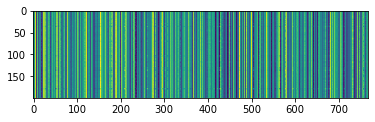

In [12]:
plt.imshow(X[0])

In [13]:
max_image_side = max([max(X[x].shape)for x in X])

In [14]:
def resize_image(image, desired_size=max_image_side):
    image = cv2.resize(image, (desired_size, desired_size), interpolation=cv2.INTER_AREA)
    return image

In [15]:
for i in range(len(X)):
    X[i] = resize_image(X[i])

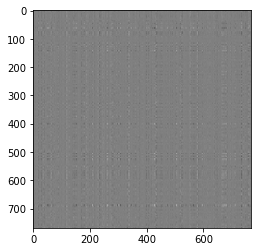

In [16]:
plt.imshow(X[0]-X[326], cmap='gray')

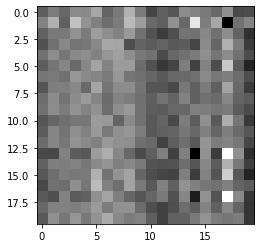

In [34]:
plt.imshow(resize_image(X[0]-X[326], 20), cmap='gray')

### Create dataset

In [19]:
class Tweets(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [23]:
len(X_train)

336

In [24]:
len(X_test)

84

In [28]:
train_loader = DataLoader(Tweets(X_train, y_train), batch_size=32, shuffle=True)
X_test_loader = DataLoader(Tweets(X_test, y_test), batch_size=32, shuffle=False)

### Create model

In [ ]:
# REVISAR CAPAS POR QUE ES MUY RARO QUE FUNCIONE
class TweetSentimentModel(nn.Model):
    def __init__(self):
        super(TweetSentimentModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(2048, 4096, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv2d(4096, 8192, kernel_size=3, stride=1, padding=1)
        self.conv11 = nn.Conv2d(8192, 16384, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(16384, 32768, kernel_size=3, stride=1, padding=1)
        self.conv13 = nn.Conv2d(32768, 65536, kernel_size=3, stride=1, padding=1)
        self.conv14 = nn.Conv2d(65536, 131072, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(131072, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = F.relu(self.conv14(x))
        x = x.flatten()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x
